In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import pybamm
from pymcmcstat.MCMC import MCMC
from pymcmcstat.settings.DataStructure import DataStructure

## DFN Model Definition

In [2]:
model = pybamm.lithium_ion.DFN()

param = model.default_parameter_values
param['Negative electrode diffusivity [m2.s-1]'] = 3.54e-14
param['Positive electrode diffusivity [m2.s-1]'] = 1.01e-13
param['Electrolyte diffusivity [m2.s-1]'] = 3.71e-10

param["Current function [A]"] = "[input]"

simulation = pybamm.Simulation(model, parameter_values=param)


t_max = 60*60*10
t_eval = np.linspace(0, t_max, num=(t_max//2))

cur_app = param['Nominal cell capacity [A.h]']/10
simulation.solve(t_eval, inputs={"Current function [A]": cur_app})

In [3]:
solution = simulation.solution
t = solution["Time [s]"]
V = solution["Terminal voltage [V]"]

## Data Generation

In [6]:
# noise with σ = 3 mV
noise = np.random.normal(loc = 0, scale = 3e-3, size = V.entries.shape)

voltage_data = V.entries + noise

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = t_eval/60, y = voltage_data, mode = 'markers', name = 'Simulated Data'))
fig.update_xaxes(title='Time (min)')
fig.update_yaxes(title='Voltage (V)')
fig.update_layout(template="simple_white", width = 600)

## Parameter Estimation

In [18]:
def dfn_model(theta):
    
    Ds_n, Ds_p, De = theta
    
    param['Negative electrode diffusivity [m2.s-1]'] = np.exp(Ds_n)
    param['Positive electrode diffusivity [m2.s-1]'] = np.exp(Ds_p)
    param['Electrolyte diffusivity [m2.s-1]'] = np.exp(De)
    
    simulation = pybamm.Simulation(model, parameter_values=param)
    simulation.solve(t_eval, inputs={"Current function [A]": cur_app})
    
    return simulation.solution["Terminal voltage [V]"].entries   

In [19]:
def ss_error(theta, pass_arg):
    
    y_hat = dfn_model(theta)
    dif = voltage_data[:y_hat.size] - y_hat
    return np.dot(dif.T, dif)
    

## Setup MCMC Simulation

In [21]:
theta0 = {"D_sn": np.log(5e-12), "D_sp": np.log(5e-12), "D_e": np.log(5e-12)}

In [22]:
# Initialize MCMC object
mcstat = MCMC()

# Add data
mcstat.data.add_data_set(x=t_eval,
                         y=voltage_data)

# Define model parameters

mcstat.parameters.add_model_parameter(name='$D_s,n$',
                                      theta0=theta0['D_sn'], 
                                      minimum=np.log(1e-16),
                                      maximum = np.log(1e-8),
                                      sample=True)

mcstat.parameters.add_model_parameter(name='$D_s,p$',
                                      theta0=theta0['D_sp'],
                                      minimum= np.log(1e-16),
                                      maximum = np.log(1e-8),
                                      sample=True)

mcstat.parameters.add_model_parameter(name='$D_e$',
                                      theta0=theta0['D_e'],
                                      minimum= np.log(1e-16),
                                      maximum = np.log(1e-8),
                                      sample=True)

In [40]:
mcstat.model_settings.define_model_settings(sos_function = ss_error)

# Define simulation options
mcstat.simulation_options.define_simulation_options(save_to_json = True, 
                                                    nsimu=7200, 
                                                    results_filename  = datetime.datetime.now().strftime("%m%d%Y_%H%M") + ".json",
                                                    updatesigma=True)

In [ ]:
# Run Simulation
mcstat.run_simulation(use_previous_results=False)

results = mcstat.simulation_results.results
names = results['names']
fullchain = results['chain']
fulls2chain = results['s2chain']
nsimu = results['nsimu']
burnin = int(nsimu/20)
chain = fullchain[burnin:, :]
s2chain = fulls2chain[burnin:, :]

mcstat.chainstats(chain, results)

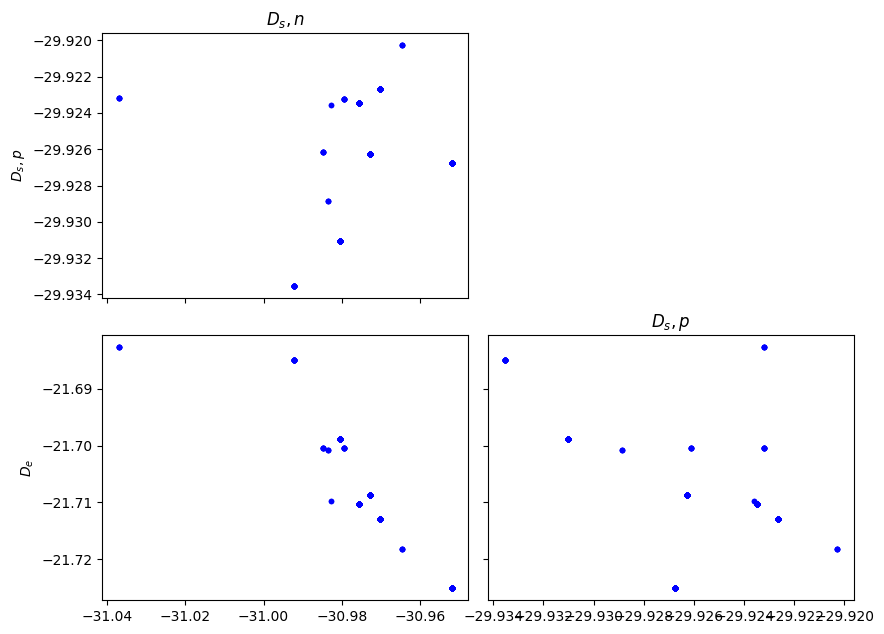

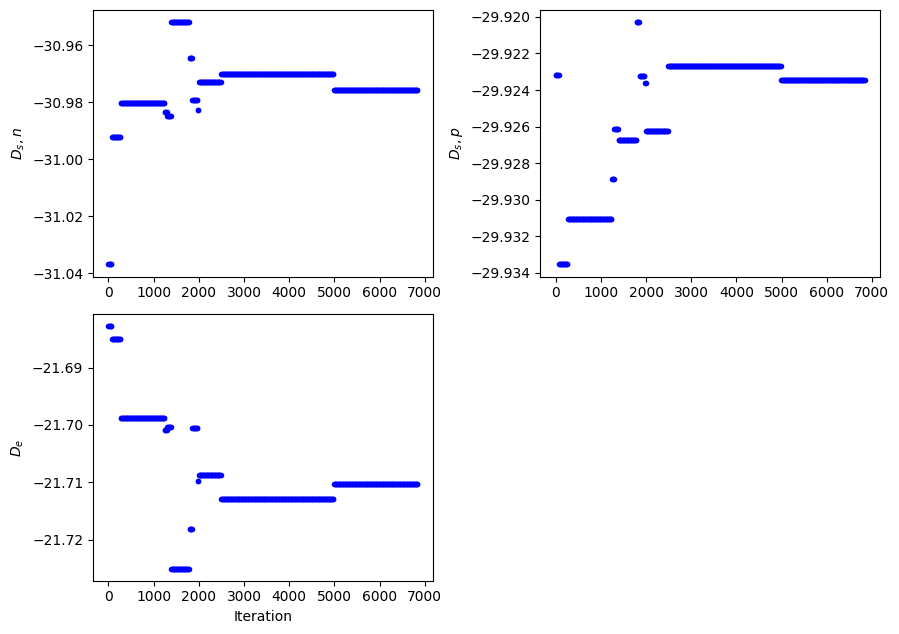

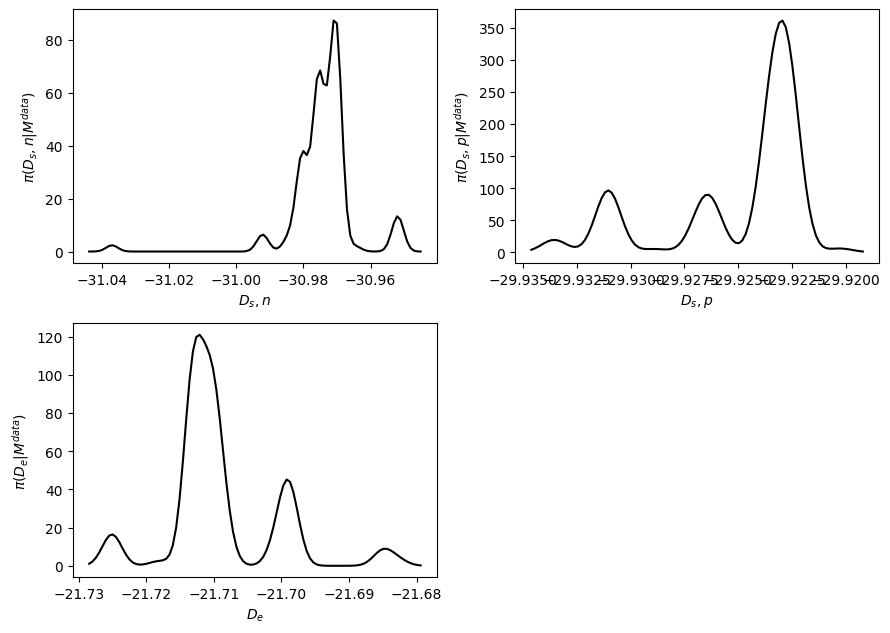

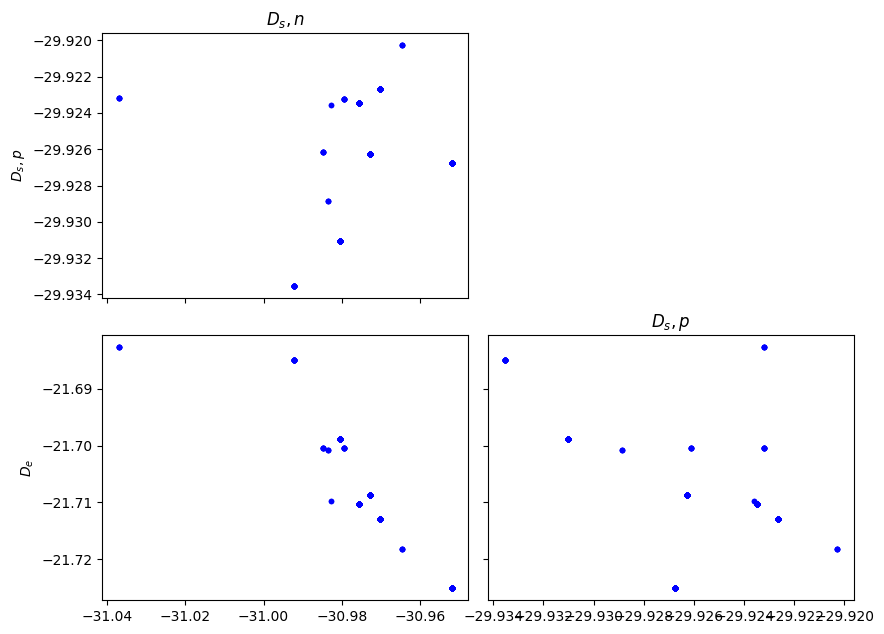

In [30]:
mcstat.mcmcplot.plot_chain_panel(chain, names, figsizeinches=(9, 7))
mcstat.mcmcplot.plot_density_panel(chain, names, figsizeinches=(9, 7))
mcstat.mcmcplot.plot_pairwise_correlation_panel(chain, names,
                                                figsizeinches=(9, 7))

In [ ]:
chain_df = pd.DataFrame(chain)
chain_df.columns = ['D_s,n', 'D_s,p','D_e']
chain_df.head()

In [ ]:
voltage_fit = dfn_model(results['theta'])
fig.add_trace(go.Scatter(x = t_eval/60, y = voltage_fit, mode = 'markers', name = 'Fit Parameters'))